# Phase 1: Data Understanding, Cleaning & Sampling
## MovieLens 32M Dataset

**Objectives:**
1. **Understand** the full dataset structure and statistics
2. **Clean** the full dataset (missing values, duplicates, integrity)
3. **Sample** 10% of clean data for computational efficiency
4. **Save** clean sampled data for subsequent phases

**Why clean before sampling?**
- Ensures sample is representative of clean data
- Full picture of data quality issues
- Reproducible: same clean base → consistent samples
- Mirrors production pipelines: Raw → Clean → Sample

**Cleaning Rules:**
- A user CAN have multiple ratings (one per movie) → Not a duplicate
- Same movieId twice in movies.csv → Duplicate, drop
- Same user rates same movie twice → Duplicate, keep LAST (latest rating)
- Movies without ratings → Drop (cannot train/evaluate)
- Movies without genres → Drop (cannot contribute to content-based)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
# ===========================================
# CONFIGURATION
# ===========================================

RAW_PATH = "D:\Courses\DL INTERNSHIP\THIRD PROJECT\data\ml-32m"
PROCESSED_PATH = 'D:/Courses/DL INTERNSHIP/THIRD PROJECT/data/processed'

SAMPLE_RATIO = 0.30  # 10% sample
CF_MIN_RATINGS = 4.5   # Minimum ratings for CF eligibility

os.makedirs(PROCESSED_PATH, exist_ok=True)

print("CONFIGURATION")
print("=" * 50)
print(f"Raw data path: {RAW_PATH}")
print(f"Output path: {PROCESSED_PATH}")
print(f"Sample ratio: {SAMPLE_RATIO:.0%}")
print(f"CF threshold: {CF_MIN_RATINGS} ratings")
print(f"Random state: {RANDOM_STATE}")

CONFIGURATION
Raw data path: D:\Courses\DL INTERNSHIP\THIRD PROJECT\data\ml-32m
Output path: D:/Courses/DL INTERNSHIP/THIRD PROJECT/data/processed
Sample ratio: 30%
CF threshold: 4.5 ratings
Random state: 42


In [3]:
# Dictionary to track all cleaning actions for final summary
cleaning_log = {
    'missing': {
        'ratings': 0,
        'movies_title': 0,
        'tags': 0,
        'links_tmdbId': 0,
        'movies_no_poster': 0,
        'ratings_no_poster': 0,
        'tags_no_poster': 0
    },
    'duplicates': {
        'ratings_found': 0,
        'ratings_removed': 0,
        'movies_found': 0,
        'movies_removed': 0,
        'tags_found': 0,
        'tags_removed': 0,
        'links_found': 0,
        'links_removed': 0
    },
    'integrity': {
        'orphan_rating_movies': 0,
        'orphan_tag_movies': 0,
        'orphan_tag_users': 0,
        'ratings_removed': 0,
        'tags_removed_movies': 0,
        'tags_removed_users': 0
    },
    'filtering': {
        'movies_no_ratings': 0,
        'movies_no_genres': 0,
        'ratings_removed_no_genre': 0,
        'tags_empty': 0,
        'tags_dup': 0
    }
}

---
# PART 1: DATA UNDERSTANDING
---

## 1.1 Load Full Dataset

In [6]:
print("=" * 60)
print("1.1 LOADING FULL DATASET")
print("=" * 60)

ratings_df = pd.read_csv(f'{RAW_PATH}/ratings.csv')
movies_df = pd.read_csv(f'{RAW_PATH}/movies.csv')
tags_df = pd.read_csv(f'{RAW_PATH}/tags.csv')
links_df = pd.read_csv(f'{RAW_PATH}/links.csv')

# Store BEFORE counts
before_counts = {
    'ratings': len(ratings_df),
    'users': ratings_df['userId'].nunique(),
    'movies': len(movies_df),
    'movies_rated': ratings_df['movieId'].nunique(),
    'tags': len(tags_df),
    'links': len(links_df)
}

print(f"\n{'Dataset':<15} {'Rows':>15} {'Columns':>10} {'Memory (MB)':>15}")
print("-" * 57)
for name, df in [('ratings', ratings_df), ('movies', movies_df), ('tags', tags_df), ('links', links_df)]:
    mem = df.memory_usage(deep=True).sum() / 1024**2
    print(f"{name:<15} {len(df):>15,} {len(df.columns):>10} {mem:>15.2f}")

total_mem = sum(df.memory_usage(deep=True).sum() for df in [ratings_df, movies_df, tags_df, links_df]) / 1024**2
print("-" * 57)
print(f"{'TOTAL':<15} {'':<15} {'':<10} {total_mem:>15.2f}")

1.1 LOADING FULL DATASET

Dataset                    Rows    Columns     Memory (MB)
---------------------------------------------------------
ratings              32,000,204          4          976.57
movies                   87,585          3           12.13
tags                  2,000,072          4          160.47
links                    87,585          3            2.00
---------------------------------------------------------
TOTAL                                              1151.18


## 1.2 Dataset Structure

In [ ]:
print("=" * 60)
print("1.2 DATASET STRUCTURE")
print("=" * 60)

for name, df in [('ratings', ratings_df), ('movies', movies_df), ('tags', tags_df), ('links', links_df)]:
    print(f"\n--- {name}.csv ---")
    print(f"Columns: {list(df.columns)}")
    print(f"Dtypes: {dict(df.dtypes)}")
    print(f"Sample:")
    print(df.head(2).to_string(index=False))

1.2 DATASET STRUCTURE

--- ratings.csv ---
Columns: ['userId', 'movieId', 'rating', 'timestamp']
Dtypes: {'userId': dtype('int64'), 'movieId': dtype('int64'), 'rating': dtype('float64'), 'timestamp': dtype('int64')}
Sample:
 userId  movieId  rating  timestamp
      1       17     4.0  944249077
      1       25     1.0  944250228

--- movies.csv ---
Columns: ['movieId', 'title', 'genres']
Dtypes: {'movieId': dtype('int64'), 'title': dtype('O'), 'genres': dtype('O')}
Sample:
 movieId            title                                      genres
       1 Toy Story (1995) Adventure|Animation|Children|Comedy|Fantasy
       2   Jumanji (1995)                  Adventure|Children|Fantasy

--- tags.csv ---
Columns: ['userId', 'movieId', 'tag', 'timestamp']
Dtypes: {'userId': dtype('int64'), 'movieId': dtype('int64'), 'tag': dtype('O'), 'timestamp': dtype('int64')}
Sample:
 userId  movieId         tag  timestamp
     22    26479 Kevin Kline 1583038886
     22    79592    misogyny 1581476297

---

## 1.3 Key Statistics (Before Cleaning)

In [ ]:
print("=" * 60)
print("1.3 KEY STATISTICS (Before Cleaning)")
print("=" * 60)

# Time range
min_ts = pd.to_datetime(ratings_df['timestamp'].min(), unit='s')
max_ts = pd.to_datetime(ratings_df['timestamp'].max(), unit='s')

# Store for comparison
before_stats = {
    'avg_rating': ratings_df['rating'].mean(),
    'median_rating': ratings_df['rating'].median(),
    'std_rating': ratings_df['rating'].std(),
    'ratings_per_user': before_counts['ratings'] / before_counts['users'],
    'ratings_per_movie': before_counts['ratings'] / before_counts['movies_rated']
}

print(f"\n{'Metric':<35} {'Value':>20}")
print("-" * 57)
print(f"{'Total ratings':<35} {before_counts['ratings']:>20,}")
print(f"{'Unique users':<35} {before_counts['users']:>20,}")
print(f"{'Movies in catalog':<35} {before_counts['movies']:>20,}")
print(f"{'Movies with ratings':<35} {before_counts['movies_rated']:>20,}")
print(f"{'Movies without ratings':<35} {before_counts['movies'] - before_counts['movies_rated']:>20,}")
print(f"{'Total tags':<35} {before_counts['tags']:>20,}")
print("-" * 57)
print(f"{'Avg rating':<35} {before_stats['avg_rating']:>20.3f}")
print(f"{'Median rating':<35} {before_stats['median_rating']:>20.1f}")
print(f"{'Std rating':<35} {before_stats['std_rating']:>20.3f}")
print("-" * 57)
print(f"{'Avg ratings per user':<35} {before_stats['ratings_per_user']:>20.1f}")
print(f"{'Avg ratings per movie':<35} {before_stats['ratings_per_movie']:>20.1f}")
print("-" * 57)
print(f"{'Rating period start':<35} {str(min_ts.date()):>20}")
print(f"{'Rating period end':<35} {str(max_ts.date()):>20}")
print(f"{'Duration (years)':<35} {(max_ts - min_ts).days / 365:>20.1f}")

1.3 KEY STATISTICS (Before Cleaning)

Metric                                             Value
---------------------------------------------------------
Total ratings                                 32,000,204
Unique users                                     200,948
Movies in catalog                                 87,585
Movies with ratings                               84,432
Movies without ratings                             3,153
Total tags                                     2,000,072
---------------------------------------------------------
Avg rating                                         3.540
Median rating                                        3.5
Std rating                                         1.059
---------------------------------------------------------
Avg ratings per user                               159.2
Avg ratings per movie                              379.0
---------------------------------------------------------
Rating period start                           

---
# PART 2: DATA CLEANING (Full Dataset)
---

## 2.1 Missing Values - IDENTIFY & CLEAN

In [ ]:
print("=" * 60)
print("2.1 MISSING VALUES")
print("=" * 60)

for name, df in [('ratings', ratings_df), ('movies', movies_df), ('tags', tags_df), ('links', links_df)]:
    missing = df.isnull().sum()
    missing_cols = missing[missing > 0]
    if len(missing_cols) == 0:
        print(f"{name}: No missing values")
    else:
        for col, count in missing_cols.items():
            pct = count / len(df) * 100
            print(f"{name}.{col}: {count:,} ({pct:.2f}%)")

2.1 MISSING VALUES
ratings: No missing values
movies: No missing values
tags.tag: 17 (0.00%)
links.tmdbId: 124 (0.14%)


In [ ]:
# Ratings
before = len(ratings_df)
ratings_df = ratings_df.dropna()
cleaning_log['missing']['ratings'] = before - len(ratings_df)
print(f"ratings: Dropped {cleaning_log['missing']['ratings']:,} rows")

# Movies - drop missing title
before = len(movies_df)
movies_df = movies_df.dropna(subset=['title'])
cleaning_log['missing']['movies_title'] = before - len(movies_df)
print(f"movies (title): Dropped {cleaning_log['missing']['movies_title']:,} rows")

# Tags - drop missing tag
before = len(tags_df)
tags_df = tags_df.dropna(subset=['tag'])
cleaning_log['missing']['tags'] = before - len(tags_df)
print(f"tags: Dropped {cleaning_log['missing']['tags']:,} rows")

# Links - drop missing tmdbId (no poster available)
before = len(links_df)
cleaning_log['missing']['links_tmdbId'] = links_df['tmdbId'].isnull().sum()
links_df = links_df.dropna(subset=['tmdbId'])
print(f"links (tmdbId): Dropped {cleaning_log['missing']['links_tmdbId']:,} rows with missing tmdbId")

# Get movieIds that have valid links (with poster)
movies_with_poster = set(links_df['movieId'])

# Remove movies without poster
before = len(movies_df)
movies_df = movies_df[movies_df['movieId'].isin(movies_with_poster)]
cleaning_log['missing']['movies_no_poster'] = before - len(movies_df)
print(f"movies: Dropped {cleaning_log['missing']['movies_no_poster']:,} movies without poster")

# Remove associated ratings
before = len(ratings_df)
ratings_df = ratings_df[ratings_df['movieId'].isin(movies_with_poster)]
cleaning_log['missing']['ratings_no_poster'] = before - len(ratings_df)
print(f"ratings: Dropped {cleaning_log['missing']['ratings_no_poster']:,} ratings for movies without poster")

# Remove associated tags
before = len(tags_df)
tags_df = tags_df[tags_df['movieId'].isin(movies_with_poster)]
cleaning_log['missing']['tags_no_poster'] = before - len(tags_df)
print(f"tags: Dropped {cleaning_log['missing']['tags_no_poster']:,} tags for movies without poster")

ratings: Dropped 0 rows
movies (title): Dropped 0 rows
tags: Dropped 17 rows
links (tmdbId): Dropped 124 rows with missing tmdbId
movies: Dropped 124 movies without poster
ratings: Dropped 4,726 ratings for movies without poster
tags: Dropped 339 tags for movies without poster


## 2.2 Duplicates - IDENTIFY & CLEAN

In [ ]:
print("=" * 60)
print("2.2 DUPLICATES")
print("=" * 60)

dup_ratings = ratings_df.duplicated(subset=['userId', 'movieId']).sum()
dup_movies = movies_df.duplicated(subset=['movieId']).sum()
dup_tags = tags_df.duplicated(subset=['userId', 'movieId', 'tag']).sum()
dup_links = links_df.duplicated(subset=['movieId']).sum()

print(f"ratings (userId+movieId): {dup_ratings:,}")
print(f"movies (movieId): {dup_movies:,}")
print(f"tags (userId+movieId+tag): {dup_tags:,}")
print(f"links (movieId): {dup_links:,}")

# Store for log
cleaning_log['duplicates']['ratings_found'] = dup_ratings
cleaning_log['duplicates']['movies_found'] = dup_movies
cleaning_log['duplicates']['tags_found'] = dup_tags
cleaning_log['duplicates']['links_found'] = dup_links

2.2 DUPLICATES
ratings (userId+movieId): 0
movies (movieId): 0
tags (userId+movieId+tag): 0
links (movieId): 0


In [ ]:
print("\n--- CLEAN ---")

# Ratings - keep last (latest rating)
before = len(ratings_df)
ratings_df = ratings_df.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId'], keep='last')
cleaning_log['duplicates']['ratings_removed'] = before - len(ratings_df)
print(f"ratings: Removed {cleaning_log['duplicates']['ratings_removed']:,} (kept latest)")

# Movies - keep first
before = len(movies_df)
movies_df = movies_df.drop_duplicates(subset=['movieId'], keep='first')
cleaning_log['duplicates']['movies_removed'] = before - len(movies_df)
print(f"movies: Removed {cleaning_log['duplicates']['movies_removed']:,}")

# Tags - keep last
before = len(tags_df)
tags_df = tags_df.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId', 'tag'], keep='last')
cleaning_log['duplicates']['tags_removed'] = before - len(tags_df)
print(f"tags: Removed {cleaning_log['duplicates']['tags_removed']:,}")

# Links - keep first
before = len(links_df)
links_df = links_df.drop_duplicates(subset=['movieId'], keep='first')
cleaning_log['duplicates']['links_removed'] = before - len(links_df)
print(f"links: Removed {cleaning_log['duplicates']['links_removed']:,}")


--- CLEAN ---
ratings: Removed 0 (kept latest)
movies: Removed 0
tags: Removed 0
links: Removed 0


## 2.3 Referential Integrity - IDENTIFY & CLEAN

In [ ]:
print("=" * 60)
print("2.3 REFERENTIAL INTEGRITY")
print("=" * 60)

movies_in_catalog = set(movies_df['movieId'])
movies_in_ratings = set(ratings_df['movieId'])
movies_in_tags = set(tags_df['movieId'])
users_in_ratings = set(ratings_df['userId'])
users_in_tags = set(tags_df['userId'])

orphan_rating_movies = movies_in_ratings - movies_in_catalog
orphan_tag_movies = movies_in_tags - movies_in_catalog
orphan_tag_users = users_in_tags - users_in_ratings

print(f"Movies in ratings but NOT in catalog: {len(orphan_rating_movies):,}")
print(f"Movies in tags but NOT in catalog: {len(orphan_tag_movies):,}")
print(f"Users in tags but NOT in ratings: {len(orphan_tag_users):,}")

cleaning_log['integrity']['orphan_rating_movies'] = len(orphan_rating_movies)
cleaning_log['integrity']['orphan_tag_movies'] = len(orphan_tag_movies)
cleaning_log['integrity']['orphan_tag_users'] = len(orphan_tag_users)

2.3 REFERENTIAL INTEGRITY
Movies in ratings but NOT in catalog: 0
Movies in tags but NOT in catalog: 0
Users in tags but NOT in ratings: 0


In [ ]:
# Remove ratings for orphan movies
before = len(ratings_df)
ratings_df = ratings_df[ratings_df['movieId'].isin(movies_in_catalog)]
cleaning_log['integrity']['ratings_removed'] = before - len(ratings_df)
print(f"ratings: Removed {cleaning_log['integrity']['ratings_removed']:,} for orphan movies")

# Remove tags for orphan movies
before = len(tags_df)
tags_df = tags_df[tags_df['movieId'].isin(movies_in_catalog)]
cleaning_log['integrity']['tags_removed_movies'] = before - len(tags_df)
print(f"tags: Removed {cleaning_log['integrity']['tags_removed_movies']:,} for orphan movies")

# Remove tags for orphan users
before = len(tags_df)
tags_df = tags_df[tags_df['userId'].isin(users_in_ratings)]
cleaning_log['integrity']['tags_removed_users'] = before - len(tags_df)
print(f"tags: Removed {cleaning_log['integrity']['tags_removed_users']:,} for orphan users")

ratings: Removed 0 for orphan movies
tags: Removed 0 for orphan movies
tags: Removed 0 for orphan users


## 2.4 Remove Movies Without Ratings

In [ ]:
print("=" * 60)
print("2.4 REMOVE MOVIES WITHOUT RATINGS")
print("=" * 60)

movies_with_ratings = set(ratings_df['movieId'].unique())
movies_without_ratings = set(movies_df['movieId']) - movies_with_ratings

print(f"Movies WITH ratings: {len(movies_with_ratings):,}")
print(f"Movies WITHOUT ratings: {len(movies_without_ratings):,}")

cleaning_log['filtering']['movies_no_ratings'] = len(movies_without_ratings)

2.4 REMOVE MOVIES WITHOUT RATINGS
Movies WITH ratings: 84,310
Movies WITHOUT ratings: 3,151


In [ ]:
print("\n--- CLEAN ---")

before = len(movies_df)
movies_df = movies_df[movies_df['movieId'].isin(movies_with_ratings)].copy()
print(f"movies: {before:,} → {len(movies_df):,} (removed {before - len(movies_df):,})")

before = len(links_df)
links_df = links_df[links_df['movieId'].isin(movies_with_ratings)].copy()
print(f"links: {before:,} → {len(links_df):,} (removed {before - len(links_df):,})")

before = len(tags_df)
tags_df = tags_df[tags_df['movieId'].isin(movies_with_ratings)].copy()
print(f"tags: {before:,} → {len(tags_df):,} (removed {before - len(tags_df):,})")


--- CLEAN ---
movies: 87,461 → 84,310 (removed 3,151)
links: 87,461 → 84,310 (removed 3,151)
tags: 1,999,716 → 1,982,440 (removed 17,276)


## 2.5 Remove Movies Without Genres

In [ ]:
print("=" * 60)
print("2.5 REMOVE MOVIES WITHOUT GENRES")
print("=" * 60)

print("\n--- IDENTIFY ---")
no_genre_mask = movies_df['genres'] == '(no genres listed)'
movies_no_genre = movies_df[no_genre_mask]

print(f"Movies with '(no genres listed)': {len(movies_no_genre):,}")
print(f"Movies with valid genres: {len(movies_df) - len(movies_no_genre):,}")

cleaning_log['filtering']['movies_no_genres'] = len(movies_no_genre)

2.5 REMOVE MOVIES WITHOUT GENRES

--- IDENTIFY ---
Movies with '(no genres listed)': 6,554
Movies with valid genres: 77,756


In [ ]:
print("\n--- CLEAN ---")
print("Rationale: Movies without genres cannot contribute to content-based recommendations.")

# Get movieIds to remove
movies_to_remove = set(movies_no_genre['movieId'])

# Remove from movies
before = len(movies_df)
movies_df = movies_df[~no_genre_mask].copy()
print(f"movies: {before:,} → {len(movies_df):,} (removed {before - len(movies_df):,})")

# Remove associated ratings
before = len(ratings_df)
ratings_df = ratings_df[~ratings_df['movieId'].isin(movies_to_remove)].copy()
cleaning_log['filtering']['ratings_removed_no_genre'] = before - len(ratings_df)
print(f"ratings: {before:,} → {len(ratings_df):,} (removed {before - len(ratings_df):,})")

# Remove associated tags
before = len(tags_df)
tags_df = tags_df[~tags_df['movieId'].isin(movies_to_remove)].copy()
print(f"tags: {before:,} → {len(tags_df):,} (removed {before - len(tags_df):,})")

# Remove associated links
before = len(links_df)
links_df = links_df[~links_df['movieId'].isin(movies_to_remove)].copy()
print(f"links: {before:,} → {len(links_df):,} (removed {before - len(links_df):,})")


--- CLEAN ---
Rationale: Movies without genres cannot contribute to content-based recommendations.
movies: 84,310 → 77,756 (removed 6,554)
ratings: 31,995,478 → 31,939,982 (removed 55,496)
tags: 1,982,440 → 1,965,915 (removed 16,525)
links: 84,310 → 77,756 (removed 6,554)


## 2.6 Clean Tags

In [ ]:
print("=" * 60)
print("2.6 CLEAN TAGS")
print("=" * 60)

before_tags = len(tags_df)

# Normalize
tags_df['tag'] = tags_df['tag'].astype(str).str.lower().str.strip()

# Remove empty
before = len(tags_df)
tags_df = tags_df[tags_df['tag'].str.len() > 0]
cleaning_log['filtering']['tags_empty'] = before - len(tags_df)
print(f"Removed empty tags: {cleaning_log['filtering']['tags_empty']:,}")

# Remove duplicates
before = len(tags_df)
tags_df = tags_df.sort_values('timestamp').drop_duplicates(subset=['userId', 'movieId', 'tag'], keep='last')
cleaning_log['filtering']['tags_dup'] = before - len(tags_df)
print(f"Removed duplicate tags: {cleaning_log['filtering']['tags_dup']:,}")

print(f"\nTags: {before_tags:,} → {len(tags_df):,}")

2.6 CLEAN TAGS
Removed empty tags: 6
Removed duplicate tags: 15

Tags: 1,965,915 → 1,965,894


## 2.7 Cleaning Complete - Before/After Comparison

In [ ]:
# Store AFTER counts (full cleaned data)
after_counts = {
    'ratings': len(ratings_df),
    'users': ratings_df['userId'].nunique(),
    'movies': len(movies_df),
    'tags': len(tags_df),
    'links': len(links_df)
}

after_stats = {
    'avg_rating': ratings_df['rating'].mean(),
    'median_rating': ratings_df['rating'].median(),
    'std_rating': ratings_df['rating'].std(),
    'ratings_per_user': after_counts['ratings'] / after_counts['users'],
    'ratings_per_movie': after_counts['ratings'] / after_counts['movies']
}

2.7 BEFORE vs AFTER CLEANING


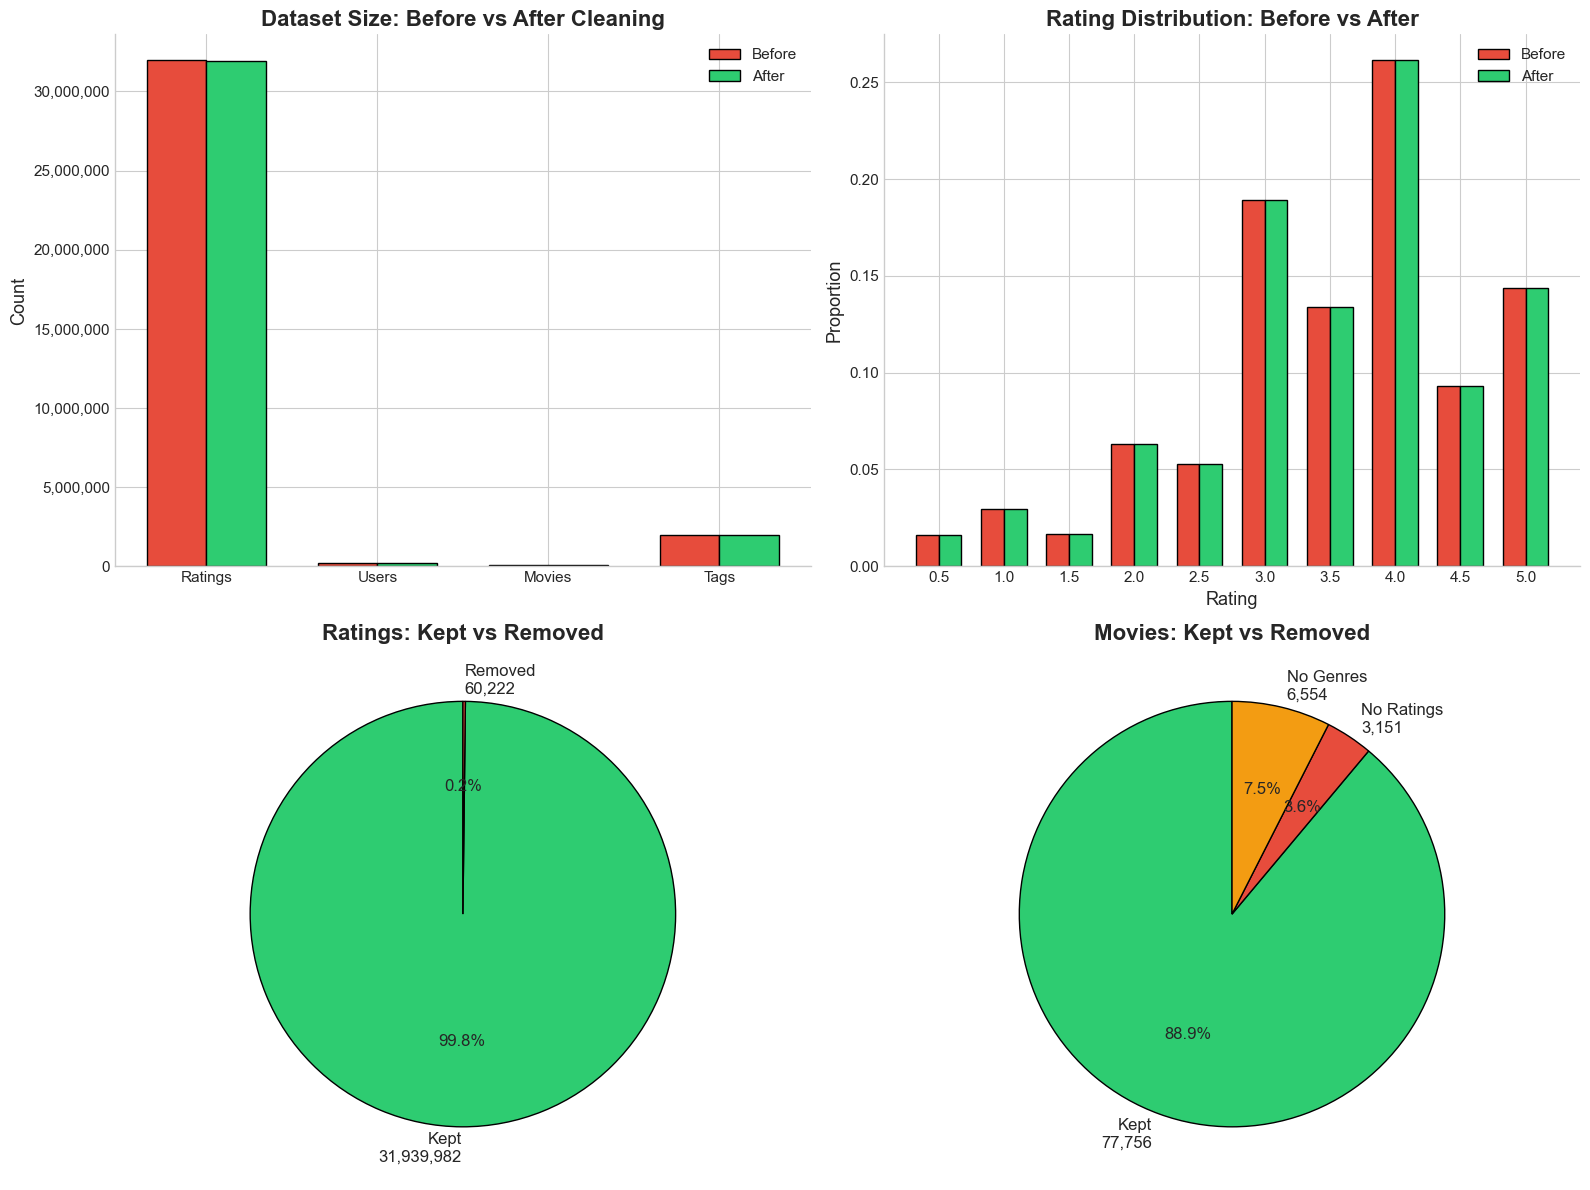

In [ ]:
# Visualization: Before vs After Cleaning
print("=" * 60)
print("2.7 BEFORE vs AFTER CLEANING")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Dataset sizes comparison
metrics = ['Ratings', 'Users', 'Movies', 'Tags']
before_vals = [before_counts['ratings'], before_counts['users'], before_counts['movies'], before_counts['tags']]
after_vals = [after_counts['ratings'], after_counts['users'], after_counts['movies'], after_counts['tags']]

x = np.arange(len(metrics))
width = 0.35

bars1 = axes[0, 0].bar(x - width/2, before_vals, width, label='Before', color='#e74c3c', edgecolor='black')
bars2 = axes[0, 0].bar(x + width/2, after_vals, width, label='After', color='#2ecc71', edgecolor='black')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, fontsize=11)
axes[0, 0].set_ylabel('Count', fontsize=13)
axes[0, 0].set_title('Dataset Size: Before vs After Cleaning', fontsize=16, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
axes[0, 0].tick_params(labelsize=11)

# 2. Rating distribution comparison
before_rating_dist = pd.read_csv(f'{RAW_PATH}/ratings.csv')['rating'].value_counts(normalize=True).sort_index()
after_rating_dist = ratings_df['rating'].value_counts(normalize=True).sort_index()

x = np.arange(len(before_rating_dist))
axes[0, 1].bar(x - width/2, before_rating_dist.values, width, label='Before', color='#e74c3c', edgecolor='black')
axes[0, 1].bar(x + width/2, after_rating_dist.values, width, label='After', color='#2ecc71', edgecolor='black')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(before_rating_dist.index.astype(str), fontsize=11)
axes[0, 1].set_xlabel('Rating', fontsize=13)
axes[0, 1].set_ylabel('Proportion', fontsize=13)
axes[0, 1].set_title('Rating Distribution: Before vs After', fontsize=16, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].tick_params(labelsize=11)

# 3. What was removed (pie chart)
removed_ratings = before_counts['ratings'] - after_counts['ratings']
kept_ratings = after_counts['ratings']
sizes = [kept_ratings, removed_ratings]
labels = [f'Kept\n{kept_ratings:,}', f'Removed\n{removed_ratings:,}']
colors = ['#2ecc71', '#e74c3c']

axes[1, 0].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
               textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1, 0].set_title('Ratings: Kept vs Removed', fontsize=16, fontweight='bold')

# 4. Movies removed breakdown
movies_kept = after_counts['movies']
movies_no_ratings_count = cleaning_log['filtering']['movies_no_ratings']
movies_no_genres_count = cleaning_log['filtering']['movies_no_genres']

sizes = [movies_kept, movies_no_ratings_count, movies_no_genres_count]
labels = [f'Kept\n{movies_kept:,}', f'No Ratings\n{movies_no_ratings_count:,}', f'No Genres\n{movies_no_genres_count:,}']
colors = ['#2ecc71', '#e74c3c', '#f39c12']

axes[1, 1].pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90,
               textprops={'fontsize': 12}, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
axes[1, 1].set_title('Movies: Kept vs Removed', fontsize=16, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

---
# PART 3: SAMPLING (10% of Clean Data)
---

## 3.1 Sampling Strategy

**Strategy:** Sample 10% of USERS, then take ALL their ratings.

**Why user-based sampling?**
- Preserves user rating history (important for CF)
- Maintains realistic user behavior patterns
- Better than random rating sampling which fragments user profiles

In [ ]:
print("=" * 60)
print("3.1 EXECUTE SAMPLING")
print("=" * 60)

all_users = ratings_df['userId'].unique()
n_sample_users = int(len(all_users) * SAMPLE_RATIO)

print(f"\nTotal users (cleaned): {len(all_users):,}")
print(f"Sample ratio: {SAMPLE_RATIO:.0%}")
print(f"Target users: {n_sample_users:,}")

# Sample users
sampled_users = np.random.choice(all_users, size=n_sample_users, replace=False)
sampled_users_set = set(sampled_users)

print(f"\nSampled {len(sampled_users):,} users")

3.1 EXECUTE SAMPLING

Total users (cleaned): 200,948
Sample ratio: 30%
Target users: 60,284

Sampled 60,284 users


In [ ]:
# Filter all dataframes to sampled users
ratings_sample = ratings_df[ratings_df['userId'].isin(sampled_users_set)].copy()
print(f"Ratings for sampled users: {len(ratings_sample):,}")

# Get movies in sample
sampled_movies = set(ratings_sample['movieId'].unique())
print(f"Movies in sample: {len(sampled_movies):,}")

# Filter other dataframes
movies_sample = movies_df[movies_df['movieId'].isin(sampled_movies)].copy()
tags_sample = tags_df[(tags_df['userId'].isin(sampled_users_set)) & (tags_df['movieId'].isin(sampled_movies))].copy()
links_sample = links_df[links_df['movieId'].isin(sampled_movies)].copy()

print(f"Movies retained: {len(movies_sample):,}")
print(f"Tags retained: {len(tags_sample):,}")
print(f"Links retained: {len(links_sample):,}")

Ratings for sampled users: 9,659,235
Movies in sample: 61,455
Movies retained: 61,455
Tags retained: 367,427
Links retained: 61,455


## 3.2 Add Rating Count and CF Eligibility

In [ ]:
print("=" * 60)
print("3.2 ADD RATING COUNT & CF ELIGIBILITY")
print("=" * 60)

# Calculate rating counts
movie_rating_counts = ratings_sample.groupby('movieId').size().reset_index(name='rating_count')

# Merge into movies
movies_sample = movies_sample.merge(movie_rating_counts, on='movieId', how='left')
movies_sample['rating_count'] = movies_sample['rating_count'].fillna(0).astype(int)

# Add CF eligibility
movies_sample['cf_eligible'] = movies_sample['rating_count'] >= CF_MIN_RATINGS

cf_eligible = movies_sample['cf_eligible'].sum()
cf_not_eligible = len(movies_sample) - cf_eligible

print(f"\nCF Eligibility (threshold = {CF_MIN_RATINGS}):")
print(f"  CF-eligible: {cf_eligible:,} ({cf_eligible/len(movies_sample)*100:.1f}%)")
print(f"  Content-based only: {cf_not_eligible:,} ({cf_not_eligible/len(movies_sample)*100:.1f}%)")

3.2 ADD RATING COUNT & CF ELIGIBILITY

CF Eligibility (threshold = 4.5):
  CF-eligible: 27,504 (44.8%)
  Content-based only: 33,951 (55.2%)


## 3.3 Optimize Data Types

In [ ]:
print("=" * 60)
print("3.3 OPTIMIZE DATA TYPES")
print("=" * 60)

# Memory before
mem_before = (
    ratings_sample.memory_usage(deep=True).sum() +
    movies_sample.memory_usage(deep=True).sum() +
    tags_sample.memory_usage(deep=True).sum() +
    links_sample.memory_usage(deep=True).sum()
) / 1024**2

print(f"\nMemory before: {mem_before:.1f} MB")

# Optimize
ratings_sample['userId'] = ratings_sample['userId'].astype('int32')
ratings_sample['movieId'] = ratings_sample['movieId'].astype('int32')
ratings_sample['rating'] = ratings_sample['rating'].astype('float32')
ratings_sample['timestamp'] = ratings_sample['timestamp'].astype('int32')

movies_sample['movieId'] = movies_sample['movieId'].astype('int32')
movies_sample['rating_count'] = movies_sample['rating_count'].astype('int32')

tags_sample['userId'] = tags_sample['userId'].astype('int32')
tags_sample['movieId'] = tags_sample['movieId'].astype('int32')
tags_sample['timestamp'] = tags_sample['timestamp'].astype('int32')

links_sample['movieId'] = links_sample['movieId'].astype('int32')
links_sample['imdbId'] = links_sample['imdbId'].astype('str')
links_sample['tmdbId'] = links_sample['tmdbId'].fillna(0).astype('int32')

# Memory after
mem_after = (
    ratings_sample.memory_usage(deep=True).sum() +
    movies_sample.memory_usage(deep=True).sum() +
    tags_sample.memory_usage(deep=True).sum() +
    links_sample.memory_usage(deep=True).sum()
) / 1024**2

print(f"Memory after: {mem_after:.1f} MB")
print(f"Reduction: {(1 - mem_after/mem_before)*100:.1f}%")

3.3 OPTIMIZE DATA TYPES

Memory before: 411.3 MB
Memory after: 261.8 MB
Reduction: 36.4%


## 3.4 Final Validation

In [ ]:
print("=" * 60)
print("3.4 FINAL VALIDATION")
print("=" * 60)

validations = [
    ('No missing values in ratings', ratings_sample[['userId', 'movieId', 'rating']].isnull().sum().sum() == 0),
    ('No duplicate ratings', ratings_sample.duplicated(subset=['userId', 'movieId']).sum() == 0),
    ('All movies have ≥1 rating', movies_sample['rating_count'].min() >= 1),
    ('All movies have genres', (movies_sample['genres'] != '(no genres listed)').all()),
    ('All rated movies in catalog', set(ratings_sample['movieId']).issubset(set(movies_sample['movieId']))),
    ('No duplicate movies', movies_sample.duplicated(subset=['movieId']).sum() == 0)
]

print("\nValidation Results:")
print("-" * 55)
all_passed = True
for check, passed in validations:
    status = "✓ PASS" if passed else "✗ FAIL"
    print(f"  {status}: {check}")
    if not passed:
        all_passed = False

print("-" * 55)
print(f"Overall: {'ALL VALIDATIONS PASSED' if all_passed else 'SOME VALIDATIONS FAILED'}")

3.4 FINAL VALIDATION

Validation Results:
-------------------------------------------------------
  ✓ PASS: No missing values in ratings
  ✓ PASS: No duplicate ratings
  ✓ PASS: All movies have ≥1 rating
  ✓ PASS: All movies have genres
  ✓ PASS: All rated movies in catalog
  ✓ PASS: No duplicate movies
-------------------------------------------------------
Overall: ALL VALIDATIONS PASSED


## 3.5 Sample Quality Verification

In [ ]:
# Sample counts
sample_counts = {
    'ratings': len(ratings_sample),
    'users': ratings_sample['userId'].nunique(),
    'movies': len(movies_sample),
    'tags': len(tags_sample),
    'links': len(links_sample),
    'cf_eligible': cf_eligible
}

sample_stats = {
    'avg_rating': ratings_sample['rating'].mean(),
    'median_rating': ratings_sample['rating'].median(),
    'std_rating': ratings_sample['rating'].std(),
    'ratings_per_user': sample_counts['ratings'] / sample_counts['users'],
    'ratings_per_movie': sample_counts['ratings'] / sample_counts['movies']
}

3.5 SAMPLE QUALITY VERIFICATION


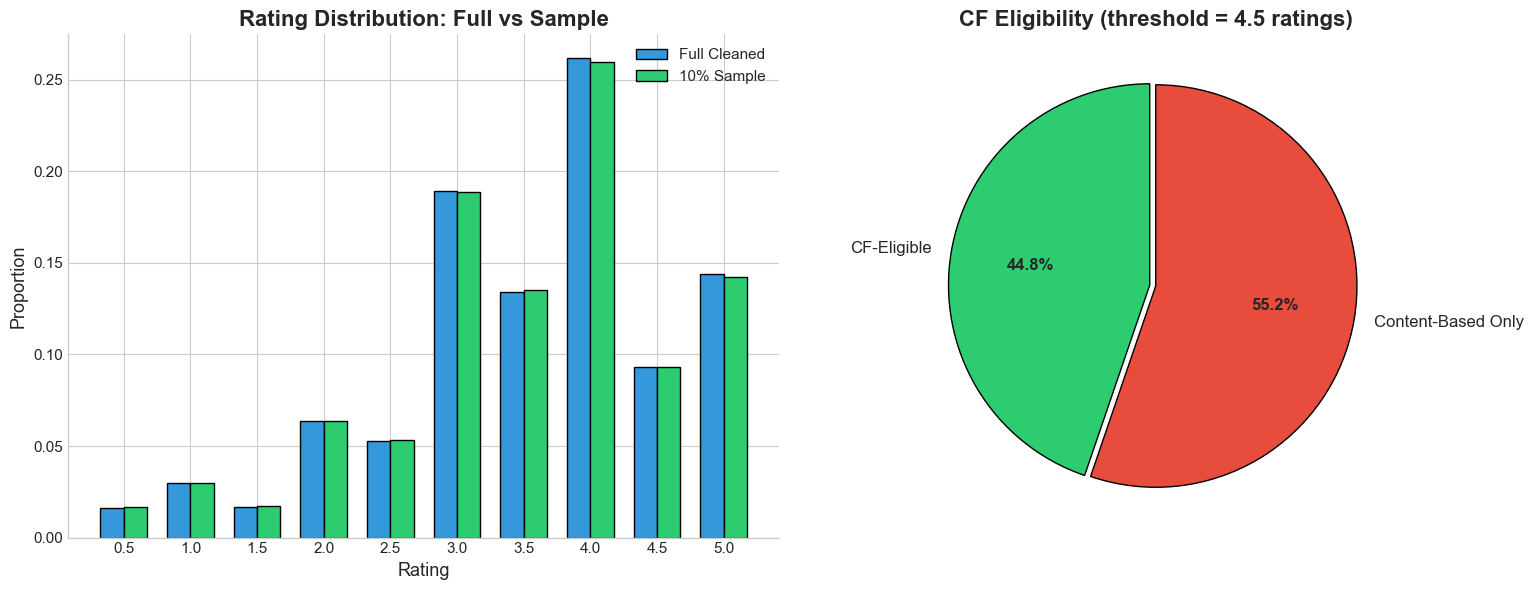


Metric                       Full Cleaned          Sample       Diff
-------------------------------------------------------------------
Avg rating                          3.541           3.534     -0.007
Std rating                          1.059           1.040     -0.019
Ratings/user                        158.9           160.2       +1.3
Ratings/movie                       410.8           157.2     -253.6

✓ Sample distributions closely match full cleaned data


In [ ]:
# Visualization: Full Cleaned vs Sample
print("=" * 60)
print("3.5 SAMPLE QUALITY VERIFICATION")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Rating distribution
full_dist = ratings_df['rating'].value_counts(normalize=True).sort_index()
sample_dist = ratings_sample['rating'].value_counts(normalize=True).sort_index()

x = np.arange(len(full_dist))
width = 0.35

axes[0].bar(x - width/2, full_dist.values, width, label='Full Cleaned', color='#3498db', edgecolor='black')
axes[0].bar(x + width/2, sample_dist.values, width, label='10% Sample', color='#2ecc71', edgecolor='black')
axes[0].set_xticks(x)
axes[0].set_xticklabels(full_dist.index.astype(str), fontsize=11)
axes[0].set_xlabel('Rating', fontsize=13)
axes[0].set_ylabel('Proportion', fontsize=13)
axes[0].set_title('Rating Distribution: Full vs Sample', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].tick_params(labelsize=11)

# CF Eligibility
sizes = [cf_eligible, cf_not_eligible]
labels = ['CF-Eligible', 'Content-Based Only']
colors = ['#2ecc71', '#e74c3c']

wedges, texts, autotexts = axes[1].pie(
    sizes, labels=labels, autopct='%1.1f%%', colors=colors,
    explode=(0.03, 0), startangle=90,
    textprops={'fontsize': 12},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1}
)
for autotext in autotexts:
    autotext.set_fontweight('bold')
axes[1].set_title(f'CF Eligibility (threshold = {CF_MIN_RATINGS} ratings)', fontsize=16, fontweight='bold')

sns.despine()
plt.tight_layout()
plt.show()

# Statistics comparison
print(f"\n{'Metric':<25} {'Full Cleaned':>15} {'Sample':>15} {'Diff':>10}")
print("-" * 67)
print(f"{'Avg rating':<25} {after_stats['avg_rating']:>15.3f} {sample_stats['avg_rating']:>15.3f} {sample_stats['avg_rating'] - after_stats['avg_rating']:>+10.3f}")
print(f"{'Std rating':<25} {after_stats['std_rating']:>15.3f} {sample_stats['std_rating']:>15.3f} {sample_stats['std_rating'] - after_stats['std_rating']:>+10.3f}")
print(f"{'Ratings/user':<25} {after_stats['ratings_per_user']:>15.1f} {sample_stats['ratings_per_user']:>15.1f} {sample_stats['ratings_per_user'] - after_stats['ratings_per_user']:>+10.1f}")
print(f"{'Ratings/movie':<25} {after_stats['ratings_per_movie']:>15.1f} {sample_stats['ratings_per_movie']:>15.1f} {sample_stats['ratings_per_movie'] - after_stats['ratings_per_movie']:>+10.1f}")

print("\n✓ Sample distributions closely match full cleaned data")

---
# PART 4: SAVE PROCESSED DATA
---

In [ ]:
print("=" * 60)
print("4.1 SAVE PROCESSED DATA")
print("=" * 60)

# Save CSV
ratings_sample.to_csv(f'{PROCESSED_PATH}/ratings_clean.csv', index=False)
movies_sample.to_csv(f'{PROCESSED_PATH}/movies_clean.csv', index=False)
tags_sample.to_csv(f'{PROCESSED_PATH}/tags_clean.csv', index=False)
links_sample.to_csv(f'{PROCESSED_PATH}/links_clean.csv', index=False)

print("\nCSV files saved:")
for f in ['ratings_clean.csv', 'movies_clean.csv', 'tags_clean.csv', 'links_clean.csv']:
    size = os.path.getsize(f'{PROCESSED_PATH}/{f}') / 1024**2
    print(f"  {f}: {size:.2f} MB")

# Save Parquet
ratings_sample.to_parquet(f'{PROCESSED_PATH}/ratings_clean.parquet', index=False)
movies_sample.to_parquet(f'{PROCESSED_PATH}/movies_clean.parquet', index=False)
tags_sample.to_parquet(f'{PROCESSED_PATH}/tags_clean.parquet', index=False)
links_sample.to_parquet(f'{PROCESSED_PATH}/links_clean.parquet', index=False)

print("\nParquet files saved:")
for f in ['ratings_clean.parquet', 'movies_clean.parquet', 'tags_clean.parquet', 'links_clean.parquet']:
    size = os.path.getsize(f'{PROCESSED_PATH}/{f}') / 1024**2
    print(f"  {f}: {size:.2f} MB")

4.1 SAVE PROCESSED DATA

CSV files saved:
  ratings_clean.csv: 252.62 MB
  movies_clean.csv: 3.31 MB
  tags_clean.csv: 12.57 MB
  links_clean.csv: 1.24 MB

Parquet files saved:
  ratings_clean.parquet: 66.78 MB
  movies_clean.parquet: 1.76 MB
  tags_clean.parquet: 3.76 MB
  links_clean.parquet: 1.20 MB


---
# PHASE 1 SUMMARY
---

In [ ]:
print("=" * 75)
print("PHASE 1 SUMMARY: DATA UNDERSTANDING, CLEANING & SAMPLING")
print("=" * 75)

print("\n" + "-" * 75)
print("PART 1: DATA UNDERSTANDING (Raw Data)")
print("-" * 75)
print(f"  Total ratings:          {before_counts['ratings']:>15,}")
print(f"  Unique users:           {before_counts['users']:>15,}")
print(f"  Movies in catalog:      {before_counts['movies']:>15,}")
print(f"  Movies with ratings:    {before_counts['movies_rated']:>15,}")
print(f"  Movies without ratings: {before_counts['movies'] - before_counts['movies_rated']:>15,}")
print(f"  Total tags:             {before_counts['tags']:>15,}")
print(f"  Rating period:          {min_ts.date()} to {max_ts.date()}")

print("\n" + "-" * 75)
print("PART 2: DATA CLEANING (Full Dataset)")
print("-" * 75)

print("\n  2.1 MISSING VALUES")
print(f"      ratings dropped:              {cleaning_log['missing']['ratings']:>10,}")
print(f"      movies (title) dropped:       {cleaning_log['missing']['movies_title']:>10,}")
print(f"      tags dropped:                 {cleaning_log['missing']['tags']:>10,}")
print(f"      links (tmdbId) dropped:       {cleaning_log['missing']['links_tmdbId']:>10,}")
print(f"      movies (no poster) dropped:   {cleaning_log['missing']['movies_no_poster']:>10,}")
print(f"      ratings (no poster) dropped:  {cleaning_log['missing']['ratings_no_poster']:>10,}")
print(f"      tags (no poster) dropped:     {cleaning_log['missing']['tags_no_poster']:>10,}")

print("\n  2.2 DUPLICATES")
print(f"      ratings found:                {cleaning_log['duplicates']['ratings_found']:>10,}")
print(f"      ratings removed (kept last):  {cleaning_log['duplicates']['ratings_removed']:>10,}")
print(f"      movies found:                 {cleaning_log['duplicates']['movies_found']:>10,}")
print(f"      movies removed:               {cleaning_log['duplicates']['movies_removed']:>10,}")
print(f"      tags found:                   {cleaning_log['duplicates']['tags_found']:>10,}")
print(f"      tags removed:                 {cleaning_log['duplicates']['tags_removed']:>10,}")
print(f"      links found:                  {cleaning_log['duplicates']['links_found']:>10,}")
print(f"      links removed:                {cleaning_log['duplicates']['links_removed']:>10,}")

print("\n  2.3 REFERENTIAL INTEGRITY")
print(f"      Orphan movies in ratings:     {cleaning_log['integrity']['orphan_rating_movies']:>10,}")
print(f"      Orphan movies in tags:        {cleaning_log['integrity']['orphan_tag_movies']:>10,}")
print(f"      Orphan users in tags:         {cleaning_log['integrity']['orphan_tag_users']:>10,}")
print(f"      Ratings removed:              {cleaning_log['integrity']['ratings_removed']:>10,}")
print(f"      Tags removed (movies):        {cleaning_log['integrity']['tags_removed_movies']:>10,}")
print(f"      Tags removed (users):         {cleaning_log['integrity']['tags_removed_users']:>10,}")

print("\n  2.4 MOVIES WITHOUT RATINGS")
print(f"      Movies removed:               {cleaning_log['filtering']['movies_no_ratings']:>10,}")

print("\n  2.5 MOVIES WITHOUT GENRES")
print(f"      Movies removed:               {cleaning_log['filtering']['movies_no_genres']:>10,}")
print(f"      Ratings removed:              {cleaning_log['filtering']['ratings_removed_no_genre']:>10,}")

print("\n  2.6 TAG CLEANING")
print(f"      Empty tags removed:           {cleaning_log['filtering']['tags_empty']:>10,}")
print(f"      Duplicate tags removed:       {cleaning_log['filtering']['tags_dup']:>10,}")

print("\n  CLEANING RESULT (Full Dataset):")
print(f"      {'Metric':<20} {'Before':>15} {'After':>15} {'Change':>15}")
print(f"      {'-'*65}")
print(f"      {'Ratings':<20} {before_counts['ratings']:>15,} {after_counts['ratings']:>15,} {after_counts['ratings'] - before_counts['ratings']:>+15,}")
print(f"      {'Users':<20} {before_counts['users']:>15,} {after_counts['users']:>15,} {after_counts['users'] - before_counts['users']:>+15,}")
print(f"      {'Movies':<20} {before_counts['movies']:>15,} {after_counts['movies']:>15,} {after_counts['movies'] - before_counts['movies']:>+15,}")
print(f"      {'Tags':<20} {before_counts['tags']:>15,} {after_counts['tags']:>15,} {after_counts['tags'] - before_counts['tags']:>+15,}")

print("\n" + "-" * 75)
print("PART 3: SAMPLING (10% of Clean Data)")
print("-" * 75)
print(f"  Strategy:               Sample {SAMPLE_RATIO:.0%} of users, keep all their ratings")
print(f"  Random state:           {RANDOM_STATE}")
print(f"  Users sampled:          {sample_counts['users']:,} / {after_counts['users']:,} ({sample_counts['users']/after_counts['users']:.1%})")
print(f"  Ratings sampled:        {sample_counts['ratings']:,} / {after_counts['ratings']:,} ({sample_counts['ratings']/after_counts['ratings']:.1%})")
print(f"  Movies in sample:       {sample_counts['movies']:,}")
print(f"  Tags in sample:         {sample_counts['tags']:,}")
print(f"  Memory optimized:       {mem_before:.1f} MB → {mem_after:.1f} MB ({(1-mem_after/mem_before)*100:.1f}% reduction)")

print("\n" + "-" * 75)
print("PART 4: OUTPUT")
print("-" * 75)
print(f"  Location:               {PROCESSED_PATH}")
print(f"  Formats:                CSV + Parquet")

print("\n" + "-" * 75)
print("VALIDATION")
print("-" * 75)
for check, passed in validations:
    status = "✓" if passed else "✗"
    print(f"  {status} {check}")

print("\n" + "=" * 75)
print("FINAL PROCESSED DATASET (10% Sample)")
print("=" * 75)
print(f"  Ratings:              {sample_counts['ratings']:>12,}")
print(f"  Users:                {sample_counts['users']:>12,}")
print(f"  Movies:               {sample_counts['movies']:>12,}")
print(f"    CF-eligible:        {sample_counts['cf_eligible']:>12,} ({sample_counts['cf_eligible']/sample_counts['movies']*100:.1f}%)")
print(f"  Tags:                 {sample_counts['tags']:>12,}")
print(f"  Links:                {sample_counts['links']:>12,}")

print("\n" + "=" * 75)
print("READY FOR PHASE 2: EDA")
print("=" * 75)

PHASE 1 SUMMARY: DATA UNDERSTANDING, CLEANING & SAMPLING

---------------------------------------------------------------------------
PART 1: DATA UNDERSTANDING (Raw Data)
---------------------------------------------------------------------------
  Total ratings:               32,000,204
  Unique users:                   200,948
  Movies in catalog:               87,585
  Movies with ratings:             84,432
  Movies without ratings:           3,153
  Total tags:                   2,000,072
  Rating period:          1995-01-09 to 2023-10-13

---------------------------------------------------------------------------
PART 2: DATA CLEANING (Full Dataset)
---------------------------------------------------------------------------

  2.1 MISSING VALUES
      ratings dropped:                       0
      movies (title) dropped:                0
      tags dropped:                         17
      links (tmdbId) dropped:              124
      movies (no poster) dropped:          124
  